# Koala Kubs CIS520 Final Project: Logistic Regression Models
The baseline model is a logistic regression model with symmetric cost function, ie. class probability threshold of 0.5:
$$
\text{Class 0 (non-diabetic)}: \text{pred} < 0.5 \\
\text{Class 1 (diabetic)}: \text{pred} \geq 0.5
$$

Because our dataset is highly imbalanced, with only ~15\% of observations classified as diabetic, an improved model would be logistic regression using an asymmetric cost function with a class probability threshold identified through tuning.

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

import matplotlib.pyplot as plt

In [ ]:
##### Import data #####
from google.colab import drive
drive.mount('/content/gdrive')
data_path = '/content/gdrive/Shareddrives/CIS520 Final Project/dataset/pre_processed/'

##### Split into train/test sets #####
# "DIABETE3" is diabetes status; drop since it is output
# "_TOTINDA" is defined by "EXERANY2" (any exercise), which is already in features
# train/test is pd df while X/y are np arrays
train = pd.read_csv(data_path + 'Train.csv')
X_train = train.drop(['DIABETE3','_TOTINDA'], axis = 1).values
y_train = train['DIABETE3'].values.astype('int64')

test = pd.read_csv(data_path + 'Test.csv')
X_test = test.drop(['DIABETE3','_TOTINDA'], axis = 1).values
y_test = test['DIABETE3'].values.astype('int64')

print("X_train dim: ", X_train.shape)
print("y_train dim: ", y_train.shape)
print("X_test dim: ", X_test.shape)
print("y_test dim: ", y_test.shape)

Mounted at /content/gdrive
X_train dim:  (135508, 22)
y_train dim:  (135508,)
X_test dim:  (33878, 22)
y_test dim:  (33878,)


In [ ]:
##### Helper functions #####
# Evaluate model performance
def eval_model(model, X, y, run_kfold=True, kfold=5, thresh=0.5):
  ### Input:
  # model: untrained classifier predicting diabetic status
  # X: (n, 22) np.array of (samples x features)
  # y: (n, 1) np.array of diabetes status (0: non-diabetic, 1: diabetic)
  # run_kfold: boolean for whether to run k-fold cross-validation (default: True)
  # kfold: integer number of folds if using cross-validation on training set (default: 5)
  # thresh: float threshold if evaluating model on test set (default: 0.5)

  ### Output:
  # acc: (kfold,1) vector of accuracies
  # f1: (kfold,1) vector of F1-scores
  # prec: (kfold,1) vector of precision scors
  # recall: (kfold,1) vector of recall scores

  # K-fold CV on training set
  if run_kfold:
    scores = cross_validate(model, X, y, 
                            scoring=['accuracy','f1','precision','recall'], cv=kfold)
    acc = scores['test_accuracy']
    f1 = scores['test_f1']
    prec = scores['test_precision']
    recall = scores['test_recall']

    # Report summary metric scores
    print('%d-fold Mean Accuracy: %.3f' % (kfold, np.mean(acc)) )
    print('%d-fold Mean F1-score: %.3f' % (kfold, np.mean(f1)))
    print('%d-fold Mean Precision: %.3f' % (kfold, np.mean(prec)) )
    print('%d-fold Mean Recall: %.3f' % (kfold, np.mean(recall)) )
  
  # Evaluate model on test set (ie. without CV)
  else:
    # Get predictions adjusted for given class weight threshold
    y_hat = model.predict_proba(X)
    y_hat = y_hat[:, 1]
    y_pred = np.zeros(y_hat.shape)
    y_pred[np.where(y_hat>=thresh)] = 1

    # Calculate evaluation metrics
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    prec = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)

    # Report summary metric scores
    print('Accuracy: %.3f' % acc )
    print('F1-score: %.3f' % f1 )
    print('Precision: %.3f' % prec )
    print('Recall: %.3f' % recall )
    
  return acc, f1, prec, recall

# Visualize confusion matrix
def conf_mat(y, y_pred):
  ### Input:
  # y: (n, 1) np.array of true diabetes status (0: non-diabetic, 1: diabetic)
  # y_pred: (n, 1) np.array of predicted diabetes status

  ### Output:
  # score: F1-score for displayed confusion matrix

  # Confusion matrix
  conf_mat = confusion_matrix(y, y_pred, labels=[1,0])
  disp = ConfusionMatrixDisplay(conf_mat, display_labels=["1","0"])
  disp.plot()
  plt.show()

  # Compute F1-score for confusion matrix
  score = f1_score(y, y_pred)
  print('F1-score for the confusion matrix: %f' % score)

  return score

# Use precision-recall curve to identify optimal threshold
def pr_curve(model, X, y, clf_name):
  ### Input:
  # model: classifier predicting diabetic status
  # X: (n, 22) np.array of (samples x features)
  # y: (n, 1) np.array of diabetes status (0: non-diabetic, 1: diabetic)
  # clf_name: string for classifier type (eg. "Logistic") for labeling on plot

  ### Output:
  # best_thresh: class weight threshold maximizing F1-score
  # best_fscore: optimal fscore given different thresholds
  # best_prec: precision associated with optimal threshold
  # best_recall: recall associated with optimal threshold

  # Predict probabilities, only keeping positive (diabetic) outcomes only
  y_hat = model.predict_proba(X)
  y_hat = y_hat[:, 1]
  
  # Calculate precision and recall for different class probability thresholds
  precision, recall, thresholds = precision_recall_curve(y, y_hat)

  # Calculate to F1-scores for different thresholds to locate optimal threshold
  fscore = (2 * precision * recall) / (precision + recall)
  ix = np.nanargmax(fscore) # index of largest score excluding NaNs due to division by 0
  best_thresh = thresholds[ix]
  best_fscore = fscore[ix]
  best_prec = precision[ix]
  best_recall = recall[ix]
  print('Best threshold: %f' % best_thresh)
  print('Best threshold F1-score: %f' % best_fscore)
  print('Best threshold Precision: %f' % best_prec)
  print('Best threshold Recall: %f' % best_recall)

  # Plot precision-recall curve
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
  plt.plot(recall, precision, marker='.', label=clf_name)
  plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

  # Confusion matrix w/ new threshold
  y_pred = np.zeros(y_hat.shape)
  y_pred[np.where(y_hat >= best_thresh)] = 1
  print('\n Confusion matrix using threshold:')
  conf_mat = confusion_matrix(y, y_pred, labels=[1,0])
  disp = ConfusionMatrixDisplay(conf_mat, display_labels=["1","0"])
  disp.plot()
  plt.show()
  # Compute the f1-score
  print('F1-score for the confusion matrix: %f' % f1_score(y,y_pred))

  return best_thresh, best_fscore, best_prec, best_recall

## Symmetric logistic regression model
Here we demonstrate how a logistic regression model with symmetric loss function (ie. *class_weight* = {0: 0.5, 1: 0.5}) that equally penalizes mistakes in classifying either class suffers due to the data's class imbalance.


 Mean evaluation metrics for 5-fold cross validation are:
5-fold Mean Accuracy: 0.837
5-fold Mean F1-score: 0.247
5-fold Mean Precision: 0.548
5-fold Mean Recall: 0.160

 Confusion matrix for training data


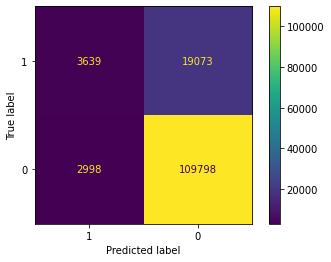

F1-score for the confusion matrix: 0.247981


0.2479811918634366

In [ ]:
##### Define BASELINE symmetric model #####
# Classes are weighted equally, mistakes classifying either class are equally penalized
clf_base = logreg(random_state=0, max_iter=500, class_weight={0:0.5, 1:0.5})

# Evaluate baseline model on training data using 5-fold CV
print("\n Mean evaluation metrics for 5-fold cross validation are:")
acc, f1, prec, recall = eval_model(clf_base, X_train, y_train)

# Confusion Matrix for training data
print('\n Confusion matrix for training data')
clf_base.fit(X_train, y_train)
y_train_pred = clf_base.predict(X_train)
conf_mat(y_train, y_train_pred)


 Mean evaluation metrics for test set:
Accuracy: 0.836
F1-score: 0.248
Precision: 0.537
Recall: 0.162

 Confusion matrix for test data


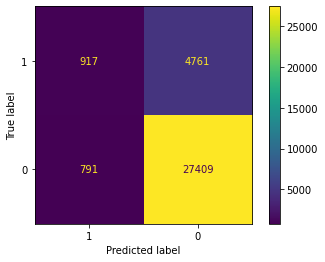

F1-score for the confusion matrix: 0.248308


In [ ]:
# Evaluate baseline model on test data
print("\n Mean evaluation metrics for test set:")
acc, f1, prec, recall = eval_model(clf_base, X_test, y_test, run_kfold=False)

# Confusion Matrix for test data
print('\n Confusion matrix for test data')
y_pred = clf_base.predict(X_test)
conf_mat(y_test, y_pred)

We see that this baseline model has a poor F1-score (train: 0.247, test:0.248), so we build a LogReg model with asymmetric class weights and also optimize thresholding to improve model performance on imbalanced data.

## Asymmetric logistic regression model
We build an asymmetric logistic regression model that penalizes mistakes in classifying the minority class (class 1, diabetic) more harshly. We use GridSearchCV to find optimal regularization and class weight parameters.

In [ ]:
##### Define asymmetric model #####
# Grid Search
param_grid = 
{'C': [1e-4, 1e-2, 1, 1e2], 
 'class_weight': [{0:1, 1:2}, {0:1, 1:3}, 
                  {0:1, 1:4}, {0:1, 1:5}, 
                  "balanced"]}

grid = GridSearchCV(logreg(random_state=0, max_iter=500), param_grid, scoring="f1")

%time grid.fit(X_train, y_train)
print(grid.best_params_)

clf_logreg = grid.best_estimator_


CPU times: user 12min 44s, sys: 6min 9s, total: 18min 54s
Wall time: 9min 38s
{'C': 0.01, 'class_weight': {0: 1, 1: 4}}


5-fold Mean Accuracy: 0.751
5-fold Mean F1-score: 0.467
5-fold Mean Precision: 0.364
5-fold Mean Recall: 0.653

 Confusion matrix for training data


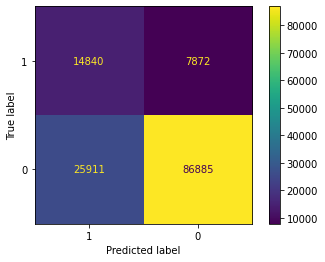

F1-score for the confusion matrix: 0.467674


0.4676740778091172

In [ ]:
# Evaluate model on training data using 5-fold CV, find optimal threshold
acc, f1, prec, recall = eval_model(clf_logreg, X_train, y_train, kfold=5)

# Confusion Matrix for training data
print('\n Confusion matrix for training data')
clf_logreg.fit(X_train, y_train)
y_train_pred = clf_logreg.predict(X_train)
conf_mat(y_train, y_train_pred)

To optimize the probability threshold at which the model classifies class 0 vs class 1, we plot the precision-recall curve for a range of thresholds to determine an optimal threshold that maximizes the F1-score ($2* \frac{precision\ *\ recall}{precision\ +\ recall}$). Code was modified from https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/


 Best threshold metrics:
Best threshold: 0.495335
Best threshold F1-score: 0.468225
Best threshold Precision: 0.362565
Best threshold Recall: 0.660796


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


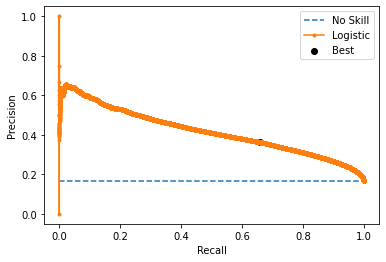


 Confusion matrix using threshold:


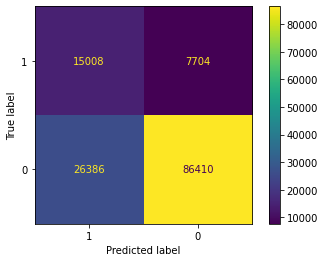

F1-score for the confusion matrix: 0.468225


In [ ]:
##### Identify optimal threshold #####
print("\n Best threshold metrics:")
best_thresh, best_fscore, best_prec, best_recall = pr_curve(clf_logreg, X_train, y_train, "Logistic")

Now that we've identified an optimal threshold of 0.495, we use this tuned and optimally thresholded asymmetric logistic regression model to evaluate its performance on the test set.

Accuracy: 0.750
F1-score: 0.468
Precision: 0.364
Recall: 0.655

 Confusion matrix for test data


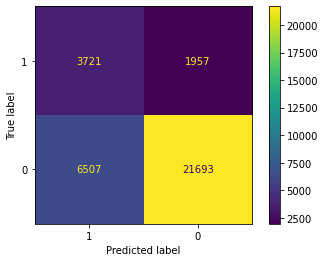

F1-score for the confusion matrix: 0.467874


In [ ]:
# Evaluate model with optimized threshold on test data
acc, f1, prec, recall = eval_model(clf_logreg, X_test, y_test, run_kfold=False, thresh=best_thresh)

# Confusion Matrix for test data
print('\n Confusion matrix for test data')
y_hat = clf_logreg.predict_proba(X_test)
y_hat = y_hat[:, 1]
y_pred = np.zeros(y_hat.shape)
y_pred[np.where(y_hat >= best_thresh)] = 1
score = conf_mat(y_test, y_pred)

## Testing under-sampling to improve performance on imbalanced dataset

In [ ]:
###### Import under-sampled dataset ######
# All diabetic (minority) samples are kept
# As many non-diabetic (majority) samples are kept to match # diabetic samples
train_under = pd.read_csv(data_path + 'Train_undersample.csv')
X_train_under = train_under.drop(['DIABETE3','_TOTINDA'], axis = 1).values
y_train_under = train_under['DIABETE3'].values.astype('int64')

CPU times: user 39.5 s, sys: 22.9 s, total: 1min 2s
Wall time: 31.8 s
{'C': 0.01}

 Mean evaluation metrics for 5-fold cross validation are:
5-fold Mean Accuracy: 0.720
5-fold Mean F1-score: 0.722
5-fold Mean Precision: 0.716
5-fold Mean Recall: 0.728

 Confusion matrix for undersampled training data


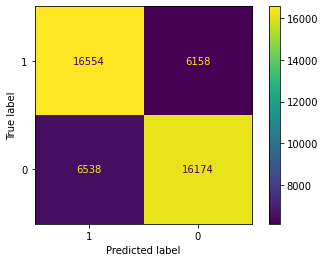

F1-score for the confusion matrix: 0.722819

 Confusion matrix for whole training data


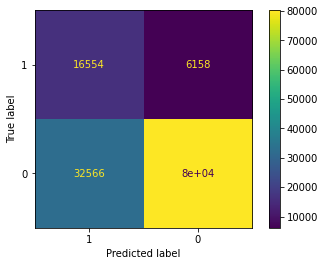

F1-score for the confusion matrix: 0.460909


0.46090878717006345

In [ ]:
##### Define symmetric model #####
param_grid = {'C': [1e-4, 1e-2, 1, 1e2]}

grid = GridSearchCV(logreg(random_state=0, max_iter=500, class_weight={0: 0.5, 1: 0.5}), param_grid, scoring="f1")

%time grid.fit(X_train_under, y_train_under)
print(grid.best_params_)

clf_underSym = grid.best_estimator_

# Evaluate baseline model on training data using 5-fold CV
print("\n Mean evaluation metrics for 5-fold cross validation are:")
acc, f1, prec, recall = eval_model(clf_underSym, X_train_under, y_train_under)

# Confusion Matrix for undersampled training data
print('\n Confusion matrix for undersampled training data')
clf_underSym.fit(X_train_under, y_train_under)
y_under_pred = clf_underSym.predict(X_train_under)
conf_mat(y_train_under, y_under_pred)

# Confusion Matrix for whole training data
print('\n Confusion matrix for whole training data')
y_train_pred = clf_underSym.predict(X_train)
conf_mat(y_train, y_train_pred)


Accuracy: 0.716
F1-score: 0.461
Precision: 0.338
Recall: 0.723

 Confusion matrix for test data


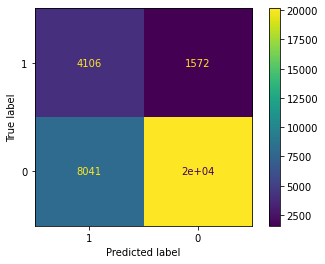

F1-score for the confusion matrix: 0.460701


In [ ]:
# Evaluate model on test data
acc, f1, prec, recall = eval_model(clf_underSym, X_test, y_test, run_kfold=False)

# Confusion Matrix for test data
print('\n Confusion matrix for test data')
y_pred = clf_underSym.predict(X_test)
score = conf_mat(y_test, y_pred)

In "real life" though, we still want to penalize false negatives more harshly than false positives, so we test the undersampling on our optimized asymmetric model.


 Mean evaluation metrics for 5-fold cross validation are:
5-fold Mean Accuracy: 0.643
5-fold Mean F1-score: 0.731
5-fold Mean Precision: 0.587
5-fold Mean Recall: 0.969

 Confusion matrix for undersampled training data


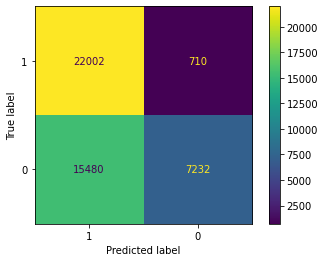

F1-score for the confusion matrix: 0.731036

 Confusion matrix for whole training data


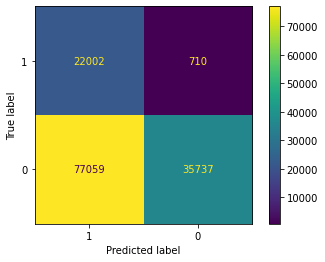

F1-score for the confusion matrix: 0.361361


0.36136089280875067

In [ ]:
##### Define asymmetric model #####
clf_underAsym = logreg(random_state=0, max_iter=500, C=0.01, class_weight={0:1, 1:4})

# Evaluate baseline model on training data using 5-fold CV
print("\n Mean evaluation metrics for 5-fold cross validation are:")
acc, f1, prec, recall = eval_model(clf_underAsym, X_train_under, y_train_under)

# Confusion Matrix for undersampled training data
print('\n Confusion matrix for undersampled training data')
clf_underAsym.fit(X_train_under, y_train_under)
y_under_pred = clf_underAsym.predict(X_train_under)
conf_mat(y_train_under, y_under_pred)

# Confusion Matrix for whole training data
print('\n Confusion matrix for whole training data')
y_train_pred = clf_underAsym.predict(X_train)
conf_mat(y_train, y_train_pred)
